In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Parameters
S0 = 83.5900
K = 84.1080
T = 0.5
r_f = 0.0513
r_d = 0.0645
sigma = 0.028145
N = 100  # Number of price steps
M = 100  # Number of time steps
S_max = 2 * K  # Maximum asset price considered


# black scholes formula
def black_scholes(S, K, T, rd, rf , sigma, option_type):
    d1 = (np.log(S / K) + (rd - rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S *np.exp(-rf * T)* norm.cdf(d1) - K * np.exp(-rd * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-rd * T) * norm.cdf(-d2) - S * np.exp(-rf * T)* norm.cdf(-d1)
    else:
        raise ValueError('option_type must be either call or put')
    
# get the option price of black scholes
option_price = black_scholes(S0, K, T, r_d, r_f, sigma, 'call')
print('Option price: ', option_price*100/S0)

Option price:  0.7944192631646292


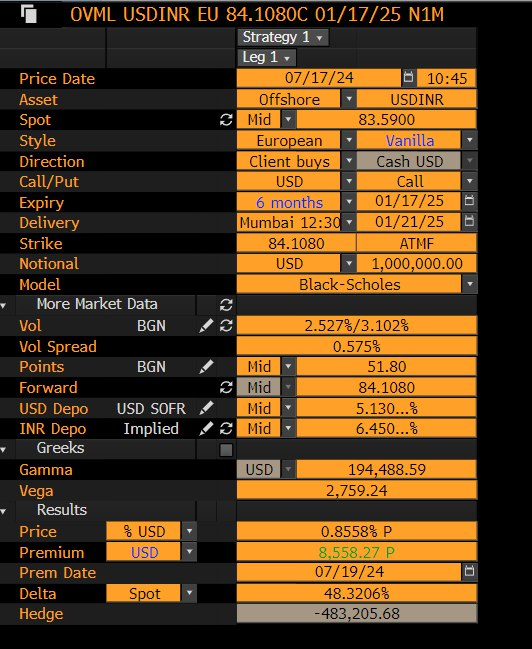

In [38]:
import numpy as np

# Parameters
S0 = 83.5900
K = 84.1080
T = 0.5
r_f = 0.0513
r_d = 0.0645
sigma = 0.028145
N = 100  # Number of price steps
M = 100  # Number of time steps
S_max = 2 * K  # Maximum asset price considered

# Grid setup
dt = T / M
dS = S_max / N

# Initialize asset prices
S = np.linspace(0, S_max, N+1)

# Initialize option values at maturity
option_values = np.maximum(S - K, 0)

# Initialize finite difference coefficients
a = np.zeros(N+1)
b = np.zeros(N+1)
c = np.zeros(N+1)

for i in range(1, N):
    a[i] = 0.5 * dt * (sigma**2 * S[i]**2 / dS**2 - (r_d - r_f) * S[i] / dS)
    b[i] = 1 - dt * (sigma**2 * S[i]**2 / dS**2 + r_d)
    c[i] = 0.5 * dt * (sigma**2 * S[i]**2 / dS**2 + (r_d - r_f) * S[i] / dS)

# Finite difference method
for j in range(M-1, -1, -1):
    for i in range(1, N):
        option_values[i] = a[i] * option_values[i-1] + b[i] * option_values[i] + c[i] * option_values[i+1]
    option_values[0] = 0  # Boundary condition for S=0
    option_values[-1] = S_max - K * np.exp(-r_d * (T - j * dt))  # Boundary condition for S_max

# Interpolate the option value at S0
option_price = np.interp(S0, S, option_values)

print(f"Option Price using Local Volatility Model: {option_price*100/S0:.4f} USD")


Option Price using Local Volatility Model: 0.7820 USD


In [25]:
def dupire_local_volatility_fx(spot, strike, expiry, iv_surface, rd, rf):
    def d1(S, K, T, rd, rf, sigma):
        if sigma * np.sqrt(T) == 0:
            return np.inf
        return (np.log(S / K) + (rd - rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    def option_price(S, K, T, rd, rf, sigma):
        d1_val = d1(S, K, T, rd, rf, sigma)
        d2_val = d1_val - sigma * np.sqrt(T)
        return S * np.exp(-rf * T) * norm.cdf(d1_val) - K * np.exp(-rd * T) * norm.cdf(d2_val)

    def partial_derivative(func, var):
        epsilon = 1e-5
        return (func(var + epsilon) - func(var - epsilon)) / (2 * epsilon)

    def local_vol(S, T):
        sigma = iv_surface(S, T)
        C = lambda K: option_price(S, K, T, rd, rf, sigma)
        dC_dK = partial_derivative(C, spot)
        d2C_dK2 = partial_derivative(lambda K: dC_dK, spot)

        numerator = 2 * (partial_derivative(lambda t: option_price(S, spot, t, rd, rf, sigma), T) +
                         (rd - rf) * spot * dC_dK +
                         rf * option_price(S, spot, T, rd, rf, sigma))
        denominator = spot ** 2 * d2C_dK2

        if denominator <= 0:
            return np.inf

        return np.sqrt(np.maximum(numerator / denominator, 0))

    return local_vol


In [26]:
def solve_pde_fd(spot, strike, rd, rf, vol_surface, expiry, S_max, S_min, M, N):
    dt = expiry / M
    dS = (S_max - S_min) / N

    # Grid for spot prices
    S = np.linspace(S_min, S_max, N + 1)
    # Grid for time
    t = np.linspace(0, expiry, M + 1)

    # Option price matrix
    V = np.zeros((N + 1, M + 1))

    # Boundary conditions
    V[:, -1] = np.maximum(S - strike, 0)  # Call option payoff
    V[0, :] = 0  # S = 0
    V[-1, :] = S_max - strike * np.exp(-rd * (expiry - t))  # S -> S_max

    for j in range(M - 1, -1, -1):
        for i in range(1, N):
            sigma = vol_surface(S[i], t[j])
            if np.isnan(sigma) or np.isinf(sigma):
                V[i, j] = 0
            else:
                alpha = 0.5 * dt * (sigma ** 2 * i ** 2 - (rd - rf) * i)
                beta = -dt * (sigma ** 2 * i ** 2 + rd)
                gamma = 0.5 * dt * (sigma ** 2 * i ** 2 + (rd - rf) * i)
                V[i, j] = alpha * V[i - 1, j + 1] + (1 + beta) * V[i, j + 1] + gamma * V[i + 1, j + 1]

    return S, V


C:\Users\91751\AppData\Local\Temp\ipykernel_9948\532491369.py:3: RuntimeWarning: invalid value encountered in sqrt
  if sigma * np.sqrt(T) == 0:
C:\Users\91751\AppData\Local\Temp\ipykernel_9948\532491369.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (np.log(S / K) + (rd - rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\91751\AppData\Local\Temp\ipykernel_9948\532491369.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2_val = d1_val - sigma * np.sqrt(T)


Option Price:  0.0


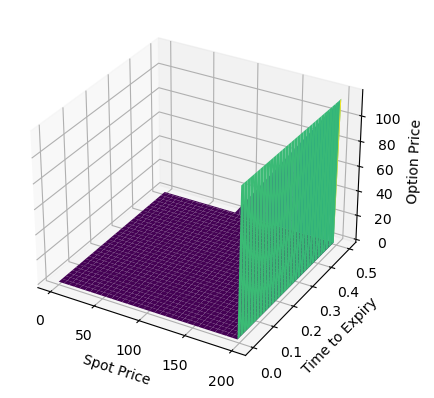

In [27]:
# Define parameters from the screenshot
spot = 83.5900
strike = 84.1320
rd = 0.05136
rf = 0.06514
expiry = 0.5
S_max = 200
S_min = 0
M = 100
N = 100

# Define a mock implied volatility surface
def iv_surface(spot, time_to_expiry):
    return 0.028145  # Using the average ATM volatility

# Define the local volatility function using Dupire's formula for FX
local_vol_fn = dupire_local_volatility_fx(spot, strike, expiry, iv_surface, rd, rf)

# Solve the PDE using finite differences
S, V = solve_pde_fd(spot, strike, rd, rf, local_vol_fn, expiry, S_max, S_min, M, N)

# Extract the option price for the given spot price
option_price = np.interp(spot, S, V[:, 0])
print("Option Price: ", option_price)

# Plot the option price surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, S = np.meshgrid(np.linspace(0, expiry, M + 1), np.linspace(S_min, S_max, N + 1))
ax.plot_surface(S, T, V, cmap='viridis')
ax.set_xlabel('Spot Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Option Price')
plt.show()
